In [69]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/scripts')
import os

import geometry as gm
#import conversion as cnv
#from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *
import meteo
import lcl
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background
from plotdistr import fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d
import warnings; warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# find data
path = '/mercury/Fabien/GS'
wrf_files = path + '/GS700_WRF_3h_surf.nc'
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [3]:
# open data
ds_tot = xr.open_dataset(wrf_files)    #mfdataset(fname_list, concat_dim='Time', combine='nested')

In [ ]:
# check no duplicates in data set time
a = ds_tot['time_counter'] 
b = ds_tot['time_counter'].drop_duplicates('time_counter')
a==b
del a,b

In [4]:
# select February (same as EURECA)
# also with : ds_tot.where(ds_tot.time_counter>0 & ds_tot.time_counter<720)

ds_hourly = ds_tot.sel(time_counter=slice('2006-02-01T00:30:00.000000000', '2006-03-01T00:30:00.000000000'))
del ds_tot

In [5]:
# select the right region

# import sea_mask
if os.path.exists('/home/alessandro/tesi_ale/prove/sea_mask.npy'):
    sea_mask = np.load('/home/alessandro/tesi_ale/prove/sea_mask.npy')

    # sea mask with no boundaries -->  NOT WORKING BECAUSE OF SHAPES
'''if os.path.exists('/home/alessandro/prove/sea_mask_nobnd.npy'):
    sea_mask_nobnd = np.load('/home/alessandro/prove/sea_mask_nobnd.npy')'''


"if os.path.exists('/home/alessandro/prove/sea_mask_nobnd.npy'):\n    sea_mask_nobnd = np.load('/home/alessandro/prove/sea_mask_nobnd.npy')"

 RETRIEVE PRESSURE FROM FILE OF DAILY OUTPUTS

In [6]:
# I dont have p in this file, 
# I'll have to import it from the daily simulation

wrf_daily = path + '/GS700_WRF_daily_3D.nc'
ds_daily = xr.open_dataset(wrf_daily)
ds_daily = ds_daily.sel(time_counter=slice('2006-02-01T00:30:00.000000000', '2006-03-01T00:30:00.000000000'))

# change order of dimensions in ds_daily

#ds_daily_sea = ds_daily.where(sea_mask, drop=False)

# select pressure and geopotential
#     lev_M: 49y_grid_M: 483x_grid_M: 975time_counter: 28
pres = ds_daily['PB'] + ds_daily['P'];         pres = pres.transpose('time_counter', 'lev_M', 'y_grid_M', 'x_grid_M') 
geop = ds_daily['PHB'] + ds_daily['PH'];       geop = geop.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')


pres_sea = pres.where(sea_mask, drop=False);   pres_seasfc = pres_sea[:,0,:,:]
geop_sea = geop.where(sea_mask, drop=False)

In [7]:
# def lon lat time
lon = ds_hourly['nav_lon'][0].values
lat = ds_hourly['nav_lat'][0].values
time = ds_hourly['time_counter'].values.astype('<M8[s]')

In [8]:
# daily variables
# select sst, q2, PBLH, T2 
sst_day_sea = ds_hourly['SST'].groupby('time_counter.day').mean();    sst_day_sea = sst_day_sea.where(sea_mask, drop=False)
q2_day_sea = ds_hourly['Q2'].groupby('time_counter.day').mean();      q2_day_sea = q2_day_sea.where(sea_mask, drop=False)
PBLH_day_sea = ds_hourly['PBLH'].groupby('time_counter.day').mean();  PBLH_day_sea.where(sea_mask, drop=False)
T2_day_sea = ds_hourly['T2'].groupby('time_counter.day').mean();      T2_day_sea = T2_day_sea.where(sea_mask, drop=False)


In [9]:
# cut out model edges -> RUN ONLY ONCE BITTE
sst_day_sea = sst_day_sea[:, 25:-25, 25:-25]
q2_day_sea = q2_day_sea[:, 25:-25, 25:-25]
PBLH_day_sea = PBLH_day_sea[:, 25:-25, 25:-25]
T2_day_sea = T2_day_sea[:, 25:-25, 25:-25]

pres_sea = pres_sea[:,:, 25:-25, 25:-25]
pres_seasfc = pres_seasfc[:, 25:-25, 25:-25]
geop_sea = geop_sea[:,:, 25:-25, 25:-25]


# SST-T2 = BUOYANCY
buoyancy = sst_day_sea - T2_day_sea

I SHOULD CUT A LITTLE BIT OF THE MODEL BOUNDARIES HERE

COMPUTE LCL WITH lcl.py

In [11]:
# compute surface saturation specific humidity
rh_day_sea = meteo.rhcalc(T2_day_sea-273.15, pres_seasfc/100., q2_day_sea)/100.        # in meteo.py, they multiplied by 100

# compute lcl with loops
LCL_day_sea = np.zeros_like(rh_day_sea)

# vectorize lcl function!
vectorized_lcl = np.vectorize(lcl.lcl)
LCL_day_sea = vectorized_lcl(pres_seasfc, T2_day_sea, rh_day_sea)



'''for t in range(len(rh[:,0,0])):     # 0,LCL_day.shape[0]
    for j in range(len(rh[0,:,0])):
        for i in range(len(rh[0,0,:])):
            LCL_day[t,j,i] = lcl.lcl(pres_seasfc[t,j,i], T2_day_sea[t,j,i], rh_day_sea[t,j,i])'''



'for t in range(len(rh[:,0,0])):     # 0,LCL_day.shape[0]\n    for j in range(len(rh[0,:,0])):\n        for i in range(len(rh[0,0,:])):\n            LCL_day[t,j,i] = lcl.lcl(pres_seasfc[t,j,i], T2_day_sea[t,j,i], rh_day_sea[t,j,i])'

In [70]:
# compute anomalies daily data
s = 100

# analyze average behaviours as well
sst_day_ave = np.zeros(sst_day_sea.shape)
PBLH_day_ave = np.zeros(PBLH_day_sea.shape)
LCL_day_ave = np.zeros(LCL_day_sea.shape)
buoya_ave = np.zeros(buoyancy.shape)

# initialize anomalies
dsst_day = np.zeros(sst_day_sea.shape)
dPBLH_day = np.zeros(PBLH_day_sea.shape)
dLCL_day = np.zeros(LCL_day_sea.shape)
dbuoya_day = np.zeros(buoyancy.shape)

In [71]:
# actual computation of smoothed fields

for t in range(0,sst_day_sea.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    sst_day_ave[t] = gm.nan_gaussian_filter(sst_day_sea[t],s)          
    dsst_day[t] = sst_day_sea[t] - sst_day_ave[t]
    
    PBLH_day_ave[t] = gm.nan_gaussian_filter(PBLH_day_sea[t],s)        
    dPBLH_day[t] = PBLH_day_sea[t] - PBLH_day_ave[t]
    
    LCL_day_ave[t] = gm.nan_gaussian_filter(LCL_day_sea[t],s)          
    dLCL_day[t] = LCL_day_sea[t] - LCL_day_ave[t]
    
    buoya_ave[t] = gm.nan_gaussian_filter(buoyancy[t],s)
    dbuoya_day[t] = buoyancy[t] - buoya_ave[t]

buoya_ave[np.isinf(buoya_ave)] = np.nan         # WHY DOESNT IT WORK ALRWEADY IN THE FILTER?
dbuoya_day[np.isinf(dbuoya_day)] = np.nan

0
10
20


In [74]:
buoya_ave[np.isinf(buoya_ave)] = np.nan
np.any( np.isinf(buoya_ave) )

# 2 3 4 15 and 16 have inf values
plt.contourf(np.isinf(buoya_ave)[3] )
plt.colorbar()

False

In [ ]:
# CHECKING BEHAVIOURA WITH BUOYANCY

#  !!!!!!!!! BUOYA_AVE HAS -INF VALUES!!!!!!!

In [76]:
# DISTRIBUTION PBLH_ave / LCL_ave vs SST_ave bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [81]:
# PERC DISTRIBUTION
x = dbuoya_day.copy()
x = np.array(x)
control = x.reshape(-1)

##### Perc distribution: PBLH
# returns:   pdist_control , pdist_var  ,  std deviation  ,   std error 

y = dPBLH_day[:,:,:].copy()
y = np.array(y)
variable = y.reshape(-1)
pdist_dbuoya, pdist_dPBLH_dbuoya, pstd_dPBLH_dbuoya, pstd_err_dPBLH_dbuoya = perc_distribution(control, variable, nbins, perc_step)
# pdist_control , pdist_var  ,  std deviation  ,   std error 


##### Perc distribution: LCL
y = dLCL_day[:,:,:].copy()
y = np.array(y)
variable = y.reshape(-1)
pdist_dbuoya, pdist_dLCL_dbuoya, pstd_dLCL_dbuoya, pstd_err_dLCL_dbuoya = perc_distribution(control, variable, nbins, perc_step)

In [82]:
# FIXED BIN DISTRIBUTION
x = dbuoya_day.copy()
x = np.array(x)
control = x.reshape(-1)

##### Fixed bin distribution: PBLH
# returns:   dist_control , dist_var  ,  std dev of mean  , num of points per bin

y = dPBLH_day[:,:,:].copy()
y = np.array(y)
variable = y.reshape(-1)
dist_dbuoya, dist_dPBLH_dbuoya, std_dPBLH_dbuoya, npoints_PBLH = fb_distribution_npoint(control, variable, nbins, perc_step)

##### Fixed bin distribution: LCL
y = dLCL_day[:,:,:].copy()
y = np.array(y)
variable = y.reshape(-1)
dist_dbuoya, dist_dLCL_dbuoya, std_dLCL_dbuoya, npoints_LCL = fb_distribution_npoint(control, variable, nbins, perc_step)

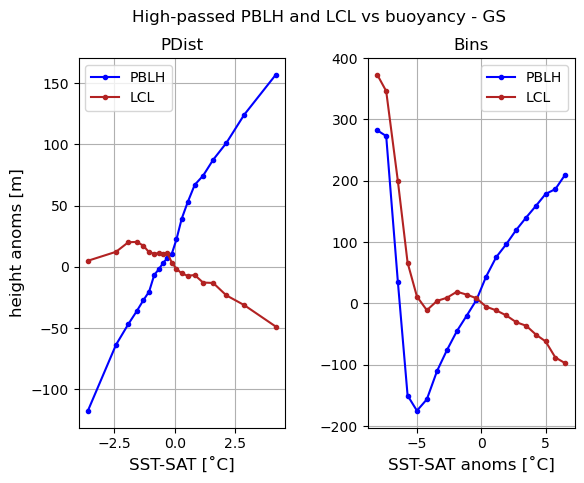

In [85]:
###### Figure
'''fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.'''

fig, ax = plt.subplots(1,2)

# PERCENTILES
ax[0].plot(pdist_dbuoya, pdist_dPBLH_dbuoya, '.-',color='b', label='PBLH')
ax[0].plot(pdist_dbuoya, pdist_dLCL_dbuoya, '.-',color='firebrick', label='LCL')
ax[0].legend()

ax[0].set_ylabel('height anoms [m]', fontsize=12); ax[0].set_xlabel('SST-SAT [˚C]', fontsize=12); 
ax[0].grid(); ax[0].set_title('PDist')


# FIXED BINS
ax[1].plot(dist_dbuoya, dist_dPBLH_dbuoya, '.-',color='b', label='PBLH')
ax[1].plot(dist_dbuoya, dist_dLCL_dbuoya, '.-',color='firebrick', label='LCL')
ax[1].legend()

#ax[1].set_ylabel('height [m]', fontsize=12); 
ax[1].set_xlabel('SST-SAT anoms [˚C]', fontsize=12); 
ax[1].grid(); ax[1].set_title('Bins')


fig.suptitle('High-passed PBLH and LCL vs buoyancy - GS')

plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)


#plt.savefig('/home/alessandro/tesi_ale/prove/plot/pbl_mask_GS/dPBLH_dLCL_vs_dbuoy.png')


In [ ]:
# CHECKING BEHAVIOURS OF AVERAGE FIELDS

In [12]:
# DISTRIBUTION PBLH_ave / LCL_ave vs SST_ave bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [13]:
# PERC DISTRIBUTION
x = sst_day_ave.copy()
control = x.reshape(-1)

##### Perc distribution: PBLH
# returns:   pdist_control , pdist_var  ,  std deviation  ,   std error 

y = PBLH_day_ave[:,:,:].copy()
variable = y.reshape(-1)
pdist_sst_ave, pdist_PBLH_sst_ave, pstd_PBLH_sst_ave, pstd_err_PBLH_sst_ave = perc_distribution(control, variable, nbins, perc_step)
# pdist_control , pdist_var  ,  std deviation  ,   std error 


##### Perc distribution: LCL
y = LCL_day_ave[:,:,:].copy()
variable = y.reshape(-1)
pdist_sst_ave, pdist_LCL_sst_ave, pstd_LCL_sst_ave, pstd_err_LCL_sst_ave = perc_distribution(control, variable, nbins, perc_step)

In [14]:
# FIXED BIN DISTRIBUTION
x = sst_day_ave.copy()
control = x.reshape(-1)

##### Fixed bin distribution: PBLH
# returns:   dist_control , dist_var  ,  std dev of mean  , num of points per bin

y = PBLH_day_ave[:,:,:].copy()
variable = y.reshape(-1)
dist_sst_ave, dist_PBLH_sst_ave, std_PBLH_sst_ave, npoints_PBLH = fb_distribution_npoint(control, variable, nbins, perc_step)

##### Fixed bin distribution: LCL
y = LCL_day_ave[:,:,:].copy()
variable = y.reshape(-1)
dist_sst_ave, dist_LCL_sst_ave, std_LCL_sst_ave, npoints_LCL = fb_distribution_npoint(control, variable, nbins, perc_step)

In [37]:
dist_PBLH_sst_ave

array([1017.72611311,  967.01606569,  880.29014779,  786.01043014,
        709.39713539,  732.44516501,  744.42034093,  781.63063362,
        827.22394126,  861.58315344,  907.88378627,  926.99679466,
        925.74591977,  896.73374176,  949.12387395, 1018.40152282,
        881.72773518, 1031.1236285 , 1022.5884162 , 1005.80871216])

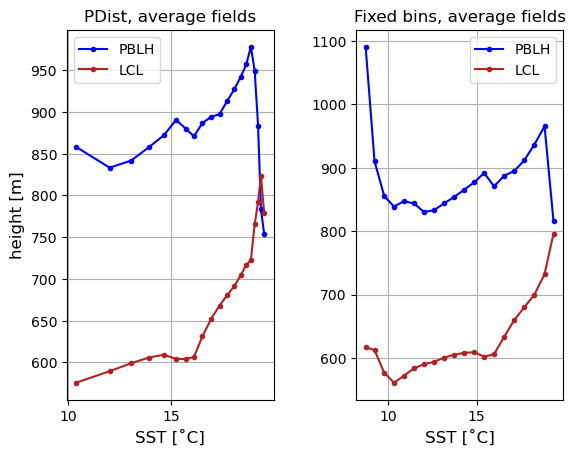

In [37]:
###### Figure
'''fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.'''

fig, ax = plt.subplots(1,2)

# PERCENTILES
ax[0].plot(pdist_sst_ave-273.15, pdist_PBLH_sst_ave, '.-',color='b', label='PBLH')
ax[0].plot(pdist_sst_ave-273.15, pdist_LCL_sst_ave, '.-',color='firebrick', label='LCL')
ax[0].legend()

ax[0].set_ylabel('height [m]', fontsize=12); ax[0].set_xlabel('SST [˚C]', fontsize=12); 
ax[0].grid(); ax[0].set_title('PDist, average fields')


# FIXED BINS
ax[1].plot(dist_sst_ave-273.15, dist_PBLH_sst_ave, '.-',color='b', label='PBLH')
ax[1].plot(dist_sst_ave-273.15, dist_LCL_sst_ave, '.-',color='firebrick', label='LCL')
ax[1].legend()

#ax[1].set_ylabel('height [m]', fontsize=12); 
ax[1].set_xlabel('SST [˚C]', fontsize=12); 
ax[1].grid(); ax[1].set_title('Fixed bins, average fields')


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.3)


#plt.savefig('/home/alessandro/prove/primi_plot/pbl_mask/average_PBL_LCL')


In [ ]:
# # DISTRIBUTION PBLH/LCL vs SST bin - DAILY
# DONE ABOVE

In [17]:
# DISTRIBUTION PBLH/LCL vs SST bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [18]:
# PERC DISTRIBUTION
x = sst_day.copy()
control = x.reshape(-1)

##### Perc distribution: PBLH
y = PBLH_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_sst, pdist_PBLH, pstd_PBLH, pstd_err_PBLH = perc_distribution(control, variable, nbins, perc_step)

##### Perc distribution: LCL
y = LCL_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_sst, pdist_LCL, pstd_LCL, pstd_err_LCL = perc_distribution(control, variable, nbins, perc_step)

NameError: name 'sst_day' is not defined

In [ ]:
# FIXED BIN DISTRIBUTION
x = sst_day.copy()
control = x.reshape(-1)
##### Fixed bin distribution: PBLH
y = PBLH_day[:,:,:].copy()
variable = y.reshape(-1)
dist_sst, dist_PBLH, std_err_PBLH, npoint_PBLH = fb_distribution_npoint(control, variable, nbins, perc_step)
##### Fixed bin distribution: LCL
y = LCL_day[:,:,:].copy()
variable = y.reshape(-1)
dist_sst, dist_LCL, std_err_LCL, npoint_LCL = fb_distribution_npoint(control, variable, nbins, perc_step)

In [ ]:
###### Figure
'''fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.'''

fig, ax = plt.subplots(2,2)    # (ax1, ax2, ax3, ax4)
#fig.tight_layout(pad=3.0)

ax[0,0].plot(pdist_sst-273.15, pdist_PBLH, '.',color='b', label='PBLH')
ax[0,0].plot(pdist_sst-273.15, pdist_LCL, '.',color='firebrick', label='LCL')
ax[0,0].legend()
ax[0,0].set_title('PDist daily, perc_step=5')
ax[0,0].set_ylabel('height [m]', fontsize=12); #ax[0,0].set_xlabel('SST [˚C]', fontsize=12); 
ax[0,0].grid()


ax[1,0].plot(pdist_sst-273.15, pdist_PBLH-pdist_LCL, '.-', color='r', mfc='none')
ax[1,0].set_title('PDist, PBLH-LCL')
ax[1,0].set_ylabel('height difference [m]', fontsize=12); 
ax[1,0].set_xlabel('SST [˚C]', fontsize=12); 
ax[1,0].grid()



ax[0,1].plot(dist_sst-273.15, dist_PBLH, '.', color='b', label='PBLH')
ax[0,1].plot(dist_sst-273.15, dist_LCL, '.', color='firebrick', label='LCL')
ax[0,1].legend()    #([dist_PBLH,dist_LCL], ['PBLH','LCL'])
ax[0,1].set_title(f'Fixed bins daily, {nbins} bins')
#ax[0,1].set_ylabel('height [m]', fontsize=12)
#ax[0,1].set_xlabel('SST [˚C]', fontsize=12); 
ax[0,1].grid()


ax[1,1].plot(dist_sst-273.15, dist_PBLH-dist_LCL, '.-', color='g', mfc='none')
ax[1,1].set_title('Fixed bins, PBLH-LCL')
#ax[1,1].set_ylabel('height difference [m]', fontsize=12)
ax[1,1].set_xlabel('SST [˚C]', fontsize=12); 
ax[1,1].grid()


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.35)

#plt.savefig('/home/alessandro/prove/primi_plot/PBLH_LCL/PBLH_LCL_good/small_dom/small_PBLH_LCL_vs_SST')

#ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST [˚C]', fontsize=12); ax1.grid()
#plt.xlim([ pdist_sst[0]-273.15 - (pdist_sst[1]-pdist_sst[0]),pdist_sst[-1]-273.15 + (pdist_sst[1]-pdist_sst[0]) ])

In [ ]:
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
# np.savetxt(path_bindist + 'pdist_sst_day.txt', pdist_sst)
np.savetxt(path_bindist + 'pdist_PBLH_sst_day.txt', pdist_PBLH)
np.savetxt(path_bindist + 'pdist_LCL_sst_day.txt', pdist_LCL)
np.savetxt(path_bindist + 'pstd_PBLH_sst_day.txt', pstd_PBLH)
np.savetxt(path_bindist + 'pstd_LCL_sst_day.txt', pstd_LCL)

In [ ]:
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/fullfield/'
np.savetxt(path_bindist + 'dist_sst_day.txt', dist_sst)
np.savetxt(path_bindist + 'dist_PBLH_sst_day.txt', dist_PBLH)
np.savetxt(path_bindist + 'dist_LCL_sst_day.txt', dist_LCL)
np.savetxt(path_bindist + 'std_err_PBLH_sst_day.txt', std_err_PBLH)
np.savetxt(path_bindist + 'std_err_LCL_sst_day.txt', std_err_LCL)
np.savetxt(path_bindist + 'npoint_PBLH_sst_day.txt', npoint_PBLH)
np.savetxt(path_bindist + 'npoint_LCL_sst_day.txt', npoint_LCL)

In [24]:
# DISTRIBUTION PBLH/LCL vs dSST bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [25]:
# PERC DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)

##### Perc distribution: PBLH
y = PBLH_day_sea[:,:,:].copy()
variable = y.values.reshape(-1)
pdist_dsst, pdist_PBLH_dsst, pstd_PBLH_dsst, pstd_err_PBLH_dsst = perc_distribution(control, variable, nbins, perc_step)

##### Perc distribution: LCL
y = LCL_day_sea[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_LCL_dsst, pstd_LCL_dsst, pstd_err_LCL_dsst = perc_distribution(control, variable, nbins, perc_step)

In [26]:
# FIXED BIN DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)

##### Fixed bin distribution: PBLH
y = PBLH_day_sea[:,:,:].copy()
variable = y.values.reshape(-1)
dist_dsst, dist_PBLH_dsst, std_err_PBLH_dsst, npoint_PBLH_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)

##### Fixed bin distribution: LCL
y = LCL_day_sea[:,:,:].copy()
variable = y.reshape(-1)
dist_dsst, dist_LCL_dsst, std_err_LCL_dsst, npoint_LCL_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)

"ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST anomalies [˚C]', fontsize=12); ax1.grid()\nplt.xlim([ pdist_dsst[0] - (pdist_dsst[1]-pdist_dsst[0]),pdist_dsst[-1] + (pdist_dsst[1]-pdist_dsst[0]) ])"

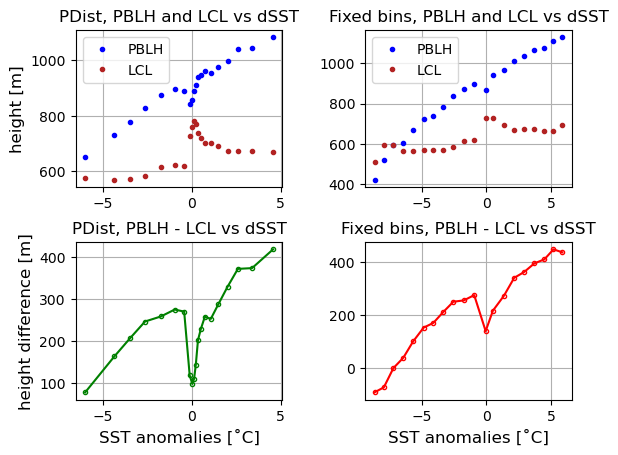

In [38]:
###### Figure
'''fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.'''

fig, ax = plt.subplots(2,2)

ax[0,0].plot(pdist_dsst, pdist_PBLH_dsst, '.',color='b', label='PBLH')
ax[0,0].plot(pdist_dsst, pdist_LCL_dsst, '.',color='firebrick', label='LCL')
ax[0,0].legend()
ax[0,0].set_title(f'PDist, PBLH and LCL vs dSST') #perc_step={perc_step}')
ax[0,0].set_ylabel('height [m]', fontsize=12); #ax[0,0].set_xlabel('SST anomalies [˚C]', fontsize=12); 
ax[0,0].grid()

ax[1,0].plot(pdist_dsst, pdist_PBLH_dsst-pdist_LCL_dsst, '.-', color='g', mfc='none')
ax[1,0].set_title('PDist, PBLH - LCL vs dSST')
ax[1,0].set_ylabel('height difference [m]', fontsize=12); ax[1,0].set_xlabel('SST anomalies [˚C]', fontsize=12); ax[1,0].grid()

ax[0,1].plot(dist_dsst, dist_PBLH_dsst, '.', color='b', label='PBLH')
ax[0,1].plot(dist_dsst, dist_LCL_dsst, '.', color='firebrick', label='LCL')
ax[0,1].legend()
ax[0,1].set_title(f'Fixed bins, PBLH and LCL vs dSST')
#ax[0,1].set_ylabel('height [m]', fontsize=12)
#ax[0,1].set_xlabel('SST anomalies [˚C]', fontsize=12); 
ax[0,1].grid()

ax[1,1].plot(dist_dsst, dist_PBLH_dsst-dist_LCL_dsst, '.-', color='r', mfc='none')
ax[1,1].set_title('Fixed bins, PBLH - LCL vs dSST')
#ax[1,1].set_ylabel('height difference [m]', fontsize=12)
ax[1,1].set_xlabel('SST anomalies [˚C]', fontsize=12); ax[1,1].grid()


plt.subplots_adjust(wspace=0.4, 
                    hspace=0.35)

#plt.savefig('/home/alessandro/prove/primi_plot/pbl_mask/PBL_LCL_vs_dSST')

'''ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST anomalies [˚C]', fontsize=12); ax1.grid()
plt.xlim([ pdist_dsst[0] - (pdist_dsst[1]-pdist_dsst[0]),pdist_dsst[-1] + (pdist_dsst[1]-pdist_dsst[0]) ])'''

In [ ]:
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
# np.savetxt(path_bindist + 'pdist_dsst_day.txt', pdist_dsst)
np.savetxt(path_bindist + 'pdist_PBLH_dsst_day.txt', pdist_PBLH_dsst)
np.savetxt(path_bindist + 'pdist_LCL_dsst_day.txt', pdist_LCL_dsst)
np.savetxt(path_bindist + 'pstd_PBLH_dsst_day.txt', pstd_PBLH_dsst)
np.savetxt(path_bindist + 'pstd_LCL_dsst_day.txt', pstd_LCL_dsst)

In [ ]:
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/fullfield/'
np.savetxt(path_bindist + 'dist_dsst_day.txt', dist_dsst)
np.savetxt(path_bindist + 'dist_PBLH_dsst_day.txt', dist_PBLH_dsst)
np.savetxt(path_bindist + 'dist_LCL_dsst_day.txt', dist_LCL_dsst)
np.savetxt(path_bindist + 'std_err_PBLH_dsst_day.txt', std_err_PBLH_dsst)
np.savetxt(path_bindist + 'std_err_LCL_dsst_day.txt', std_err_LCL_dsst)
np.savetxt(path_bindist + 'npoint_PBLH_dsst_day.txt', npoint_PBLH_dsst)
np.savetxt(path_bindist + 'npoint_LCL_dsst_day.txt', npoint_LCL_dsst)

In [30]:
# DISTRIBUTION dPBLH/dLCL vs dSST bin - DAILY
perc_step = 5
nbins = int(100/perc_step) # Number of bins

In [31]:
# PERC DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)

##### Perc distribution: PBLH
y = dPBLH_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dPBLH_dsst, pstd_dPBLH_dsst, pstd_err_dPBLH_dsst = perc_distribution(control, variable, nbins, perc_step)

##### Perc distribution: LCL
y = dLCL_day[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dLCL_dsst, pstd_dLCL_dsst, pstd_err_dLCL_dsst = perc_distribution(control, variable, nbins, perc_step)

In [32]:
# FIXED BIN DISTRIBUTION
x = dsst_day.copy()
control = x.reshape(-1)

##### Fixed bin distribution: PBLH
y = dPBLH_day[:,:,:].copy()
variable = y.reshape(-1)
dist_dsst, dist_dPBLH_dsst, std_err_dPBLH_dsst, npoint_dPBLH_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)

##### Fixed bin distribution: LCL
y = dLCL_day[:,:,:].copy()
variable = y.reshape(-1)
dist_dsst, dist_dLCL_dsst, std_err_dLCL_dsst, npoint_dLCL_dsst = fb_distribution_npoint(control, variable, nbins, perc_step)

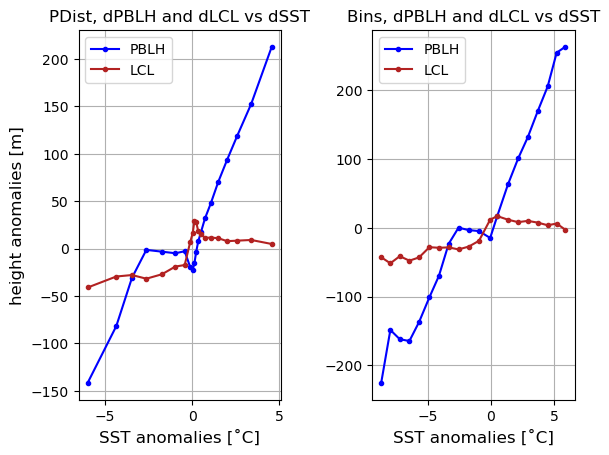

In [39]:
###### Figure
'''fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.'''

fig, ax = plt.subplots(1,2)


ax[0].plot(pdist_dsst, pdist_dPBLH_dsst, '.-',color='b', label='PBLH')
ax[0].plot(pdist_dsst, pdist_dLCL_dsst, '.-',color='firebrick', label='LCL')
ax[0].legend()

ax[0].set_ylabel('height anomalies [m]', fontsize=12); ax[0].set_xlabel('SST anomalies [˚C]', fontsize=12); 
ax[0].grid(); ax[0].set_title('PDist, dPBLH and dLCL vs dSST')
plt.xlim([ dist_dsst[0] - (dist_dsst[1]-dist_dsst[0]),dist_dsst[-1] + (dist_dsst[1]-dist_dsst[0]) ])




ax[1].plot(dist_dsst, dist_dPBLH_dsst, '.-',color='b', label='PBLH')
ax[1].plot(dist_dsst, dist_dLCL_dsst, '.-',color='firebrick', label='LCL')
ax[1].legend()

#ax[1].set_ylabel('height anoms[m]', fontsize=12); 
ax[1].set_xlabel('SST anomalies [˚C]', fontsize=12); 
ax[1].grid(); ax[1].set_title('Bins, dPBLH and dLCL vs dSST')
plt.xlim([ dist_dsst[0] - (dist_dsst[1]-dist_dsst[0]),dist_dsst[-1] + (dist_dsst[1]-dist_dsst[0]) ])


plt.subplots_adjust(wspace=0.45, 
                    hspace=0.3)


#plt.savefig('/home/alessandro/prove/primi_plot/pbl_mask/dPBL_dLCL_vs_dSST')

In [ ]:
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
# np.savetxt(path_bindist + 'pdist_dsst_day.txt', pdist_dsst)
np.savetxt(path_bindist + 'pdist_dPBLH_dsst_day.txt', pdist_dPBLH_dsst)
np.savetxt(path_bindist + 'pdist_dLCL_dsst_day.txt', pdist_dLCL_dsst)
np.savetxt(path_bindist + 'pstd_dPBLH_dsst_day.txt', pstd_dPBLH_dsst)
np.savetxt(path_bindist + 'pstd_dLCL_dsst_day.txt', pstd_dLCL_dsst)

In [ ]:
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/fullfield/'
np.savetxt(path_bindist + 'dist_dsst_day.txt', dist_dsst)
np.savetxt(path_bindist + 'dist_dPBLH_dsst_day.txt', dist_dPBLH_dsst)
np.savetxt(path_bindist + 'dist_dLCL_dsst_day.txt', dist_dLCL_dsst)
np.savetxt(path_bindist + 'std_err_dPBLH_dsst_day.txt', std_err_dPBLH_dsst)
np.savetxt(path_bindist + 'std_err_dLCL_dsst_day.txt', std_err_dLCL_dsst)
np.savetxt(path_bindist + 'npoint_dPBLH_dsst_day.txt', npoint_dPBLH_dsst)
np.savetxt(path_bindist + 'npoint_dLCL_dsst_day.txt', npoint_dLCL_dsst)

In [ ]:
# HOURLY DATA

In [ ]:
# hourly varaibles
# select sst, q2, U, PBLH
sst = ds['SST'].values*seamask
PBLH = ds['PBLH'].values*seamask

In [ ]:
# read HOURLY LCL
LCL_file = '/media/fabien/DAGOBAH1/WRF_EUREC4A/CNT/FEB/LCL.nc'
ds_lcl = xr.open_dataset(LCL_file)

In [ ]:
LCL = ds_lcl['LCL'].values*seamask

In [ ]:
# compute anomalies hourly data
s = 50
dsst = np.zeros(sst.shape)
dPBLH = np.zeros(PBLH.shape); dLCL = np.zeros(LCL.shape)
for t in range(0,sst.shape[0]):
    if t % 100 == 0:
        print(t)
    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst[t],s)*seamask
    dsst[t] = sst[t] - sst_ave
    PBLH_ave = gm.nan_gaussian_filter(PBLH[t],s)*seamask
    dPBLH[t] = PBLH[t] - PBLH_ave
    LCL_ave = gm.nan_gaussian_filter(LCL[t],s)*seamask
    dLCL[t] = LCL[t] - LCL_ave

In [ ]:
# DISTRIBUTION dPBLH/dLCL vs dSST bin - HOURLY
thrsld_n = 100
perc_step = 5
nbins = int(100/perc_step) # Number of bins
x = dsst.copy()
control = x.reshape(-1)
##### Perc distribution: dPBLH
y = dPBLH[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dPBLH, pstd_err_dPBLH = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: dPBLH
dist_dsst, dist_dPBLH, std_err_dPBLH, npoint_dPBLH = fb_distribution_mod(control, variable, nbins, thrsld_n, perc_step)
##### Perc distribution: dLCL
y = dLCL[:,:,:].copy()
variable = y.reshape(-1)
pdist_dsst, pdist_dLCL, pstd_err_dLCL = perc_distribution(control, variable, nbins, perc_step)
##### Fixed bin distribution: dLCL
dist_dsst, dist_dLCL, std_err_dLCL, npoint_dLCL = fb_distribution_mod(control, variable, nbins, thrsld_n, perc_step)

In [ ]:
###### Figure
fig = plt.figure(figsize=(6., 6.), constrained_layout=True)
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[1:, :3]) # 2d distributions.

# ax1.errorbar(dist_dsst, dist_dPBLH, std_err_dPBLH, fmt='o', color='b', mfc='none')
# ax1.errorbar(pdist_dsst, pdist_dPBLH, pstd_err_dPBLH, fmt='.',color='b')
# ax1.errorbar(dist_dsst, dist_dLCL, std_err_dLCL, fmt='o', color='firebrick', mfc='none')
# ax1.errorbar(pdist_dsst, pdist_dLCL, pstd_err_dLCL, fmt='.',color='firebrick')

ax1.plot(dist_dsst, dist_dPBLH, 'o', color='b', mfc='none')
ax1.plot(pdist_dsst, pdist_dPBLH, '.',color='b')
ax1.plot(dist_dsst, dist_dLCL, 'o', color='firebrick', mfc='none')
ax1.plot(pdist_dsst, pdist_dLCL, '.',color='firebrick')

ax1.plot(dist_dsst, dist_dPBLH-dist_dLCL, '.-', color='g', mfc='none')

ax1.set_ylabel('height [m]', fontsize=12); ax1.set_xlabel('SST anomalies [˚C]', fontsize=12); ax1.grid()
plt.xlim([ dist_dsst[0] - + (dist_dsst[1]-dist_dsst[0]),dist_dsst[-1] + (dist_dsst[1]-dist_dsst[0]) ])

In [ ]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/'
# PERC DISTRIBUTION
np.savetxt(path_bindist + 'pdist_dsst.txt', pdist_dsst)
np.savetxt(path_bindist + 'pdist_dPBLH.txt', pdist_dPBLH)
np.savetxt(path_bindist + 'pdist_dLCL.txt', pdist_dLCL)
np.savetxt(path_bindist + 'pstd_err_dPBLH.txt', pstd_err_dPBLH)
np.savetxt(path_bindist + 'pstd_err_dLCL.txt', pstd_err_dLCL)
# FB DISTRIBUTION (no point threshold)
np.savetxt(path_bindist + 'dist_dsst.txt', dist_dsst)
np.savetxt(path_bindist + 'dist_dPBLH.txt', dist_dPBLH)
np.savetxt(path_bindist + 'dist_dLCL.txt', dist_dLCL)
np.savetxt(path_bindist + 'std_err_dPBLH.txt', std_err_dPBLH)
np.savetxt(path_bindist + 'std_err_dLCL.txt', std_err_dLCL)
np.savetxt(path_bindist + 'npoint_dPBLH.txt', npoint_dPBLH)
np.savetxt(path_bindist + 'npoint_dLCL.txt', npoint_dLCL)

In [ ]:
# corr length
L = 80
nskip = int(L/3)
nt = int(3)
nbin = 50

In [ ]:
# linear regression PBLH vs SST
x = dsst[::nt,::nskip,::nskip].copy()
# y = dPBLH[::nt,::nskip,::nskip].copy()
y = (dPBLH - dLCL)[::nt,::nskip,::nskip].copy()
linreg_res, corr_coeff, p_value = slopes_r_p(x,y)

fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
# scatterplot lin regression 
title = "PBLH' vs SST' - sigma "
xlabel = 'SST anomalies [°C]'; ylabel = "PBLH anomalies [m]"
fig1 = scatterplot_fit(x, y, linreg_res, s, title, xlabel, ylabel, fig)
# histogram 2d 
plt.subplot(1,2,2)
fig2 = hist2d(x, y, s, nbin, title, xlabel, ylabel, fig)

In [ ]:
# PLOT DATA

In [ ]:
##############
# BOXPLOT
##############

In [ ]:
# BOXPLOT
def box_plot(data, labels, edge_color, fill_color, ax):
    medianprops = dict(linestyle='-', linewidth=1, color=edge_color)
    meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor=edge_color, markersize=4)
    flierprops = dict(marker='o', markeredgecolor=edge_color, markersize=6,
                  linestyle='none')
    
    bp = ax.boxplot(data, labels=labels, medianprops=medianprops, flierprops=flierprops, \
                    meanprops=meanpointprops, showmeans=True, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

def box_plot_pos(data, offset, labels, edge_color, fill_color, ax):
    medianprops = dict(linestyle='-', linewidth=1, color=edge_color)
    meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor=edge_color, markersize=4)
    flierprops = dict(marker='o', markeredgecolor=edge_color, markersize=6,
                  linestyle='none')
    
    pos = np.arange(len(labels))+offset
    
    bp = ax.boxplot(data, positions= pos, labels=labels, medianprops=medianprops, flierprops=flierprops, \
                    meanprops=meanpointprops, showmeans=True, patch_artist=True)
    
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       
        
    return bp

In [ ]:
# build sst perc classes
perc = np.arange(10,100,10)
sst_day_perc = np.zeros(len(perc))
dsst_day_perc = np.zeros(len(perc))

for i in range(0,len(perc)):
    sst_day_perc[i] = np.nanpercentile(sst_day,perc[i])
    dsst_day_perc[i] = np.nanpercentile(dsst_day,perc[i])

In [ ]:
bin_PBLH_sst = []; bin_LCL_sst = []
bin_PBLH_dsst = []; bin_LCL_dsst = []
bin_dPBLH_dsst = []; bin_dLCL_dsst = []
labels = []; dlabels = []
for i in range(0,len(perc)):
    if i == 0:
        pblh_sst = PBLH_day[sst_day < sst_day_perc[i]]; lcl_sst = LCL_day[sst_day < sst_day_perc[i]]
        pblh_dsst = PBLH_day[dsst_day < dsst_day_perc[i]]; lcl_dsst = LCL_day[dsst_day < dsst_day_perc[i]]
        dpblh_dsst = dPBLH_day[dsst_day < dsst_day_perc[i]]; dlcl_dsst = dLCL_day[dsst_day < dsst_day_perc[i]]
    else:
        pblh_sst = PBLH_day[(sst_day >= sst_day_perc[i-1]) & (sst_day < sst_day_perc[i])]
        pblh_dsst = PBLH_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
        dpblh_dsst = dPBLH_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
        lcl_sst = LCL_day[(sst_day >= sst_day_perc[i-1]) & (sst_day < sst_day_perc[i])]
        lcl_dsst = LCL_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
        dlcl_dsst = dLCL_day[(dsst_day >= dsst_day_perc[i-1]) & (dsst_day < dsst_day_perc[i])]
    # create lists
    bin_PBLH_sst.append(pblh_sst); bin_LCL_sst.append(lcl_sst)
    bin_PBLH_dsst.append(pblh_dsst); bin_LCL_dsst.append(lcl_dsst)
    bin_dPBLH_dsst.append(dpblh_dsst); bin_dLCL_dsst.append(dlcl_dsst)
    labels.append(str(np.round(sst_day_perc[i]-273.15,2)))
    dlabels.append(str(np.round(dsst_day_perc[i],2)))
# adding last class, when data > 90perc sst
pblh_sst = PBLH_day[sst_day >= sst_day_perc[-1]]; lcl_sst = LCL_day[sst_day >= sst_day_perc[-1]]
pblh_dsst = PBLH_day[dsst_day >= dsst_day_perc[-1]]; lcl_dsst = LCL_day[dsst_day >= dsst_day_perc[-1]]
dpblh_dsst = dPBLH_day[dsst_day >= dsst_day_perc[-1]]; dlcl_dsst = dLCL_day[dsst_day >= dsst_day_perc[-1]]
bin_PBLH_sst.append(pblh_sst); bin_LCL_sst.append(lcl_sst)
bin_PBLH_dsst.append(pblh_dsst); bin_LCL_dsst.append(lcl_dsst)
bin_dPBLH_dsst.append(dpblh_dsst); bin_dLCL_dsst.append(dlcl_dsst)
labels.append(' '); dlabels.append(' ')       

In [ ]:
# BOXPLOT SOVRAPPOSTO
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 12))

bp1 = box_plot(bin_PBLH_sst, labels, 'blue', 'white', ax1)
bp2 = box_plot(bin_LCL_sst, labels, 'firebrick', 'white', ax1)
ax1.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax1.set_xlabel('SST [˚C]', fontsize=12); ax1.set_ylabel('height [m]', fontsize=12)

bp1 = box_plot(bin_PBLH_dsst, dlabels, 'blue', 'white', ax2)
bp2 = box_plot(bin_LCL_dsst, dlabels, 'firebrick', 'white', ax2)
ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax2.set_xlabel('SST anom [˚C]', fontsize=12); ax2.set_ylabel('height [m]', fontsize=12)

bp1 = box_plot(bin_dPBLH_dsst, dlabels, 'blue', 'white', ax3)
bp2 = box_plot(bin_dLCL_dsst, dlabels, 'firebrick', 'white', ax3)
ax3.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax3.set_xlabel('SST anom [˚C]', fontsize=12); ax3.set_ylabel('height anom [m]', fontsize=12)

In [ ]:
# BOXPLOT AFFIANCATO
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(10, 12))

offs = 0.25

bp1 = box_plot_pos(bin_PBLH_sst, 0, labels, 'blue', 'white', ax1)
bp2 = box_plot_pos(bin_LCL_sst, offs, labels, 'firebrick', 'white', ax1)
ax1.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax1.set_xlabel('SST [˚C]', fontsize=12); ax1.set_ylabel('height [m]', fontsize=12)
ax1.set_xticks(np.arange(len(labels)))

bp1 = box_plot_pos(bin_PBLH_dsst, 0, dlabels, 'blue', 'white', ax2)
bp2 = box_plot_pos(bin_LCL_dsst, offs, dlabels, 'firebrick', 'white', ax2)
ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax2.set_xlabel('SST anom [˚C]', fontsize=12); ax2.set_ylabel('height [m]', fontsize=12)
ax2.set_xticks(np.arange(len(labels)))

bp1 = box_plot_pos(bin_dPBLH_dsst, 0, dlabels, 'blue', 'white', ax3)
bp2 = box_plot_pos(bin_dLCL_dsst, offs, dlabels, 'firebrick', 'white', ax3)
ax3.legend([bp1["boxes"][0], bp2["boxes"][0]], ['PBLH', 'LCL'])
ax3.set_xlabel('SST anom [˚C]', fontsize=12); ax3.set_ylabel('height anom [m]', fontsize=12)
ax3.set_xticks(np.arange(len(labels)))

In [ ]:
# HOURLY

In [ ]:
bin_dPBLH = [dPBLH[dsst < -1.5], \
            dPBLH[(dsst >= -1.5) & (dsst < -1)], \
            dPBLH[(dsst >= -1) & (dsst < -0.5)], \
            dPBLH[(dsst >= -0.5) & (dsst < 0)], \
            dPBLH[(dsst >= 0) & (dsst < 0.5)], \
            dPBLH[(dsst >= 0.5) & (dsst < 1)], \
            dPBLH[dsst >= 1]]
bin_dLCL = [dLCL[dsst < -1.5], \
            dLCL[(dsst >= -1.5) & (dsst < -1)], \
            dLCL[(dsst >= -1) & (dsst < -0.5)], \
            dLCL[(dsst >= -0.5) & (dsst < 0)], \
            dLCL[(dsst >= 0) & (dsst < 0.5)], \
            dLCL[(dsst >= 0.5) & (dsst < 1)], \
            dLCL[dsst >= 1]]

dlabels = ['-1.5', '-1', '-0.5', '0', '0.5', '1', '1+']

In [ ]:
fig, ax = plt.subplots()
bp1 = box_plot_pos(bin_dPBLH, 0, dlabels, 'blue', 'white')
bp2 = box_plot_pos(bin_dLCL, 0.2, dlabels, 'firebrick', 'white')
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['dPBLH', 'dLCL'])
ax.set_xticks(np.arange(len(labels)))
ax.set_xlabel('SST [˚C]', fontsize=12); ax.set_ylabel('height [m]', fontsize=12)

In [ ]:
# READ DATA

In [ ]:
# DAILY
# PERC DISTRIBUTION
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
pdist_sst = np.loadtxt(path_bindist + 'pdist_sst.txt')
pdist_PBLH = np.loadtxt(path_bindist + 'pdist_PBLH.txt')
pdist_LCL = np.loadtxt(path_bindist + 'pdist_LCL.txt')
pstd_err_PBLH = np.loadtxt(path_bindist + 'pstd_PBLH.txt')
pstd_err_LCL = np.loadtxt(path_bindist + 'pstd_LCL.txt')
# FB DISTRIBUTION (no point threshold)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/'
dist_sst = np.loadtxt(path_bindist + 'dist_sst.txt')
dist_PBLH = np.loadtxt(path_bindist + 'dist_PBLH.txt')
dist_LCL = np.loadtxt(path_bindist + 'dist_LCL.txt')
std_err_PBLH = np.loadtxt(path_bindist + 'std_err_PBLH.txt')
std_err_LCL = np.loadtxt(path_bindist + 'std_err_LCL.txt')
npoint_PBLH = np.loadtxt(path_bindist + 'npoint_PBLH.txt')
npoint_LCL = np.loadtxt(path_bindist + 'npoint_LCL.txt')

In [ ]:
# HOURLY
# PERC DISTRIBUTION
pdist_dsst = np.loadtxt(path_bindist + 'pdist_dsst.txt')
pdist_dPBLH = np.loadtxt(path_bindist + 'pdist_dPBLH.txt')
pdist_dLCL = np.loadtxt(path_bindist + 'pdist_dLCL.txt')
pstd_err_dPBLH = np.loadtxt(path_bindist + 'pstd_err_dPBLH.txt')
pstd_err_dLCL = np.loadtxt(path_bindist + 'pstd_err_dLCL.txt')
# FB DISTRIBUTION (no point threshold)
dist_dsst = np.loadtxt(path_bindist + 'dist_dsst.txt')
dist_dPBLH = np.loadtxt(path_bindist + 'dist_dPBLH.txt')
dist_dLCL = np.loadtxt(path_bindist + 'dist_dLCL.txt')
std_err_dPBLH = np.loadtxt(path_bindist + 'std_err_dPBLH.txt')
std_err_dLCL = np.loadtxt(path_bindist + 'std_err_dLCL.txt')
npoint_dPBLH = np.loadtxt(path_bindist + 'npoint_dPBLH.txt')
npoint_dLCL = np.loadtxt(path_bindist + 'npoint_dLCL.txt')

In [ ]:
# OLD STUFF

In [ ]:
# grid and geographical coordinates of seemingly good points; 
# format: [j,i] i.e. [lat, lon]
# sure there is a better way to do it

# small rectangle
small_gpoints = [[350,410],[350,265],[65,265],[65,410]]; small_gpoints=np.array(small_gpoints)
small_coords = np.zeros_like(small_gpoints)

for i in range(len(small_gpoints[:,0])):
    small_coords[i,0], small_coords[i,1] = ds_tot.nav_lat.sel(y=small_gpoints[i,0],x=small_gpoints[i,1]), ds_tot.nav_lon.sel(y=small_gpoints[i,0],x=small_gpoints[i,1])

small_coords=np.array(small_coords)


# large rectangle
large_gpoints = [[410,410],[65,410],[65,800],[410,800]]; large_gpoints=np.array(large_gpoints)
large_coords = np.zeros_like(large_gpoints)

for i in range(len(large_gpoints[:,0])):
    large_coords[i,0], large_coords[i,1] = ds_tot.nav_lat.sel(y=large_gpoints[i,0],x=large_gpoints[i,1]),\
                                           ds_tot.nav_lon.sel(y=large_gpoints[i,0],x=large_gpoints[i,1])
    
large_coords=np.array(large_coords)


# optional expansion
add_gpoints = [[410,800],[65,800],[65,900],[410,900]]; add_gpoints=np.array(add_gpoints)
add_coords = np.zeros_like(add_gpoints)

for i in range(len(small_gpoints[:,0])):
    add_coords[i,0], add_coords[i,1] = ds_tot.nav_lat.sel(y=add_gpoints[i,0],x=add_gpoints[i,1]), \
                                       ds_tot.nav_lon.sel(y=add_gpoints[i,0],x=add_gpoints[i,1])

add_coords=np.array(add_coords)

In [ ]:
minlon = min(small_coords[:,1]) ; maxlon = max(small_coords[:,1])      
minlat = min(small_coords[:,0]) ; maxlat = max(small_coords[:,0])     

In [ ]:
# domain selection new
'''mask_lon = (ds_tot.nav_lon_grid_M >= min(large_coords[:,1])) & (ds_tot.nav_lon_grid_M <= max(large_coords[:,1]))
mask_lat = (ds_tot.nav_lat_grid_M >= min(large_coords[:,0])) & (ds_tot.nav_lat_grid_M <= max(large_coords[:,0]))'''



# select domain - large box
mask_lon = (ds_month.nav_lon >= minlon) & (ds_month.nav_lon <= maxlon)
mask_lat = (ds_month.nav_lat >= minlat) & (ds_month.nav_lat <= maxlat)
ds_domain = ds_month.where(mask_lon & mask_lat, drop=True)